## Deep Learning (AI5100): Assignment-2
###Topic: Convolutional Neural Networks

### Submitted By,
  ### **Akash K S**
  ### **CS22MTECH11012** 

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as trans
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading dataset 
(train_X, train_Y), (test_X, test_Y) = cifar10.load_data()

170498071/170498071 [==============================] - 17s 0us/step


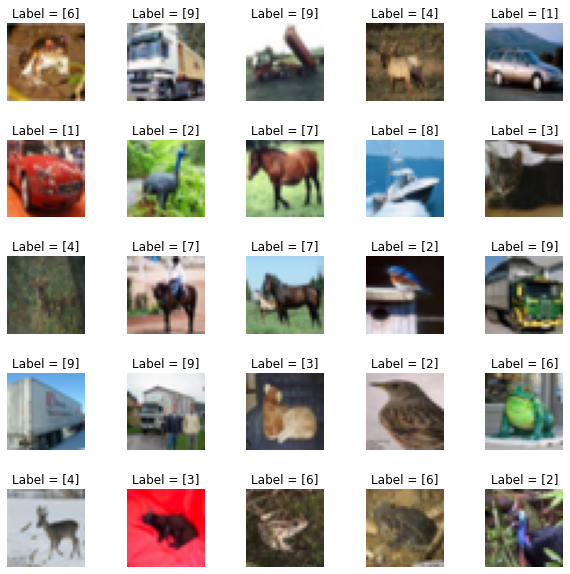

In [3]:
# Plot the first 25 images in the training set
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axs = axs.ravel()
for i in range(25):
    axs[i].imshow(train_X[i])
    axs[i].set_title("Label = {}".format(train_Y[i]))
    axs[i].axis('off')
plt.show()

In [4]:
# check dimension of input
train_X.shape

(50000, 32, 32, 3)

**1. Convolution function**: It accepts an image input, a filter kernel, stride, padding and the non-
linear function. The function must convolve the input image (after padding if specified) with the kernel (at the specified stride size) and generate an output activation after applying the specified
non-linearity. Verify with the standard options for the non-linear activation functions - sigmoid,
tanh, ReLU, Parametric ReLU (PReLU). Display the input image (e.g. small image of the IITH
logo), the filter kernel and the output activation map. Ensure that your function can accept
multi-channel input and a corresponding kernel volume.(6)

In [5]:
# defining padding
def pad_input(input_image, padding):
    
    # Create a tensor of zeros with the required padded shape
    padded_input = torch.zeros((input_image.shape[0], input_image.shape[1] + 2*padding, input_image.shape[2] + 2*padding))
    
    # Copy the input image tensor to the center of the padded tensor
    # The ":" indicates that we want to include all elements along that dimension
    # The "padding:padding+input_image.shape[1]" and "padding:padding+input_image.shape[2]" slices
    # specify the subset of the padded tensor where the input tensor should be copied
    padded_input[:, padding:padding+input_image.shape[1], padding:padding+input_image.shape[2]] = input_image
    
    # Return the padded tensor
    return padded_input


In [6]:
# Convolution function
def conv(padded_input, kernel, num_of_kernels, stride):
    
    # Get dimensions of input, kernel and required number of kernels
    H , W = padded_input.shape[1], padded_input.shape[2]
    C, h, w = kernel.shape
    D = num_of_kernels
    
    # Calculate output dimensions
    output_height = int((H - h) / stride + 1)
    output_width = int((W - w) / stride + 1)
    
    # Initialize output tensor to zeros
    conv_map = torch.zeros(D, output_height, output_width)
    
    # Perform convolution operation
    for d in range(D):  # for each kernel/filter
        for i in range(output_height):  # slide over the height of padded_input
            for j in range(output_width):  # slide over the width of padded_input
                for c in range(C):  # for each channel
                    # Apply the corresponding filter for the current channel
                    conv_map[d, i, j] += torch.sum(torch.mul((padded_input[c, i*stride:i*stride+h, j*stride:j*stride+w]), kernel[c, :, :]))
    
    return conv_map


In [7]:
# defining all activation functions
def sigmoid(x):
    # Sigmoid activation function
    #return 1 / (1 + torch.exp(-x))
    return torch.sigmoid(x)

def tanh(x):
    # Tanh activation function
    return 2 / (1 + torch.exp(-2 * x)) - 1

def relu(x):
    # ReLU activation function
    return torch.maximum(x, torch.tensor(0.0))

def prelu(x, a=0.1):
    # PReLU activation function
    output = torch.zeros_like(x)
    output[x >= 0] = x[x >= 0]
    output[x < 0] = x[x < 0] * a
    return output

**2. Pooling function**: It accepts as input the activation map output from the convolution function,
a pooling function, and stride. The function must output the appropriately pooled activation map.
Display the input activation map and the pooled output.

In [8]:
# pooling from scratch which accepts as input the activation map output from the convolution function,a pooling function, and stride.
# we can display the pooling output only for the first time it is called, hence I was used flag, where flag =1 for the pooling_first_time and flag = 0 for the pooling_second_time

def pooling(feature_map, pooling_function, kernel, stride, flag):
    #image
    D, H, W = feature_map.shape
    k = kernel
    
    #finding size 
    out_height = (H - k) // stride + 1
    out_width = (W - k) // stride + 1
    
    #initialize pooling map
    pool_map =torch.zeros(D, out_height, out_width)

    for d in range(D):
      for i in range(out_height):
        for j in range(out_width):
           region = feature_map[d, i*stride:i*stride+k, j*stride:j*stride+k]

           if pooling_function == 'max':
                pool_map[d, i, j] = torch.max(region)

           elif pooling_function == 'avg':
                #torch.mean() returns a single tensor, so no need of [0]
                pool_map[d, i, j] = torch.mean(region)

           else:
                raise ValueError("Invalid pooling function")

    if(flag):
      # Display input activation map and pooled output
      fig, ax = plt.subplots(1, 2, figsize=(10, 3))
      ax[0].imshow(feature_map[0])
      ax[0].set_title('Input Activation Map')
      ax[1].imshow(pool_map[0])
      ax[1].set_title('Pooled Output')
      plt.show()
     
    return pool_map
            


**3. Convolution layer function**: It accepts as input a volume (image or activation maps), number of
filters, kernel dimensions, stride, padding and the non-linear function. The function must convolve
the input volume (after padding if specified) with each of the kernels (at the specified stride size)
and generates an output activation volume after applying the specified non-linearity. Display the
input image or activation maps, the filter kernels and the output activation maps. Verify that the
output of this function does indeed have the expected size (W × H × C) as discussed in class.

In [9]:
#cov func from scratch

def convolution(input_image, kernel, stride, padding, num_of_kernels, non_linear_function):
    # Calculate padding if specified
    if padding > 0:
        padded_input = pad_input(input_image, padding)
    else:
        padded_input = input_image
    
    # Perform convolution
    out = conv(padded_input, kernel, num_of_kernels, stride)

    # Apply non-linear activation function
    if non_linear_function == 'sigmoid':
        out = sigmoid(out)
    elif non_linear_function == 'tanh':
        out = tanh(out)
    elif non_linear_function == 'relu':
        out = relu(out)
    elif non_linear_function == 'prelu':
        out = prelu(out)
    else:
        raise ValueError("Invalid non-linear activation function")
    
    # Rescale images for display
    input_image_display = input_image[0, :, :]
    kernel_display = kernel[0, :, :]
    out_display = out[0, :, :]
    
    # Plot the images side by side
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(input_image_display)
    ax[0].set_title('Input Image')
    ax[1].imshow(kernel_display)
    ax[1].set_title('Filter Kernel')
    ax[2].imshow(out_display)
    ax[2].set_title('Output Activation Map')
    plt.show()
    
    return out


**4. Pooling layer function**: It accepts as input the activation map volume, the pooling function,
stride, and generates a pooled output volume. Display the input and output volumes. A special
case for performing Global Average Pooling should also be provided.

#### Note: This question is similar to Q2, hence I have just showed a case of permorming GAP.

In [10]:
#GAP layer
def GAP(feature_map):
    # Take the mean over the height and width dimensions of the feature map
    # leaving only the channel dimension
    pooling_map = torch.mean(feature_map, dim=(1,2))

    return pooling_map

**5. Flattening (unraveling) function:** It accepts as input the activation map volume output by the
pooling layer and generates a vector of a specified size. It is important to note that this function
has a weight matrix associated with it whose size is chosen such that the input and desired output
sizes are matched.

In [11]:
# Define flatten function
def flatten(pooled_map, output_size):
    D, H, W = pooled_map.shape
    
    # Initialize flattened output array
    flattened_output = np.zeros(D*H*W)
    
    # Flatten pooled map into a 1D array
    i = 0
    for d in range(D):
        for h in range(H):
            flattened_output[i:i+W] = pooled_map[d, h, :]
            i += W

    # Generate weight matrix with random values
    weight_matrix = np.random.rand(output_size, flattened_output.shape[0])
    
    # Multiply weight matrix with flattened map to get final flattened output
    flattened_output = weight_matrix.dot(flattened_output)
    
    return flattened_output


**6. Multilayer Perceptron (MLP) function**: It accepts as input a vector, the number of hidden
layers, the size of each hidden layer, the non-linear function, and the size of the output layer. This
function should generate an output vector of the specified size. Generate the output with and
without the softmax function applied to the output layer. (5)

In [12]:
# Calculates the softmax of a tensor along its last dimension.
def softmax(x):
    exp_x = torch.exp(x)
    sum_exp_x = torch.sum(exp_x, dim=-1, keepdim=True)
    return exp_x / sum_exp_x

In [13]:
# MLP layer
def mlp_layer(input, num_hidden_layers, hidden_layer_size, non_linear_func, num_output_nodes):
    
    # Initialize weights and biases for the hidden layers
    h_weights = []
    h_bias = []
    in_size = input.shape[0]
    for i in range(num_hidden_layers):
        h_weights.append(torch.randn(in_size, hidden_layer_size))
        h_bias.append(torch.randn(hidden_layer_size))
        in_size = hidden_layer_size
    
    # Compute the output of the hidden layers
    hidden_layer_output = input
    for i in range(num_hidden_layers):
        h = non_linear_func(torch.matmul(h_weights[i].T, hidden_layer_output) + h_bias[i])
        hidden_layer_output = h
    
    # Initialize weights and biases for the output layer
    o_weights = torch.randn(in_size, num_output_nodes)
    o_bias = torch.randn(num_output_nodes)

    # Compute the output of the output layer (without softmax applied)
    out_layer_output = torch.matmul(o_weights.T, hidden_layer_output) + o_bias

    # Compute the output of the output layer (with softmax applied)
    out_layer_softmax = softmax(out_layer_output)

    # display
    print("MLP output without softmax : ",out_layer_output)
    print("MLP output with softmax : ",out_layer_softmax)

    return out_layer_softmax


**7. Feed forward layer**: Finally, use the functions you have written to implement a CNN with the following architecture. The CNN must accept an image input and output a vector of appropriate dimension. In other words, the function must effectively implement the feed-forward path in a CNN. (12)

• Input image of size 32 × 32 × 3. Use images from the CIFAR-10 dataset.

• Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.

• Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.

• Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.

• Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.

• A Global Average Pooling (GAP) layer.

• An MLP with one hidden layer (size same as input) that accepts as input the previous layer’snoutput and maps it to 10 output nodes. Use sigmoid activation for the MLP (softmax in the o/p layer).

Verify that your composition of function accepts and image input and outputs a vector.

In [14]:
def feed_forward_path(image_input):

  #transform image to a tensor
  image_transform = trans.Compose([trans.ToTensor()])
  image = image_transform(image_input)
  
  #check dimension
  print("Dimension of input image : \n", image.size())

  #using edge detector filter
  # filter_2d = torch.tensor([[-1., -1., -1.], [-1., 8., -1.], [-1., -1., -1.]])
  # filter = filter_2d.repeat(3,1,1)
  filter = np.random.rand(3, 3, 3)
  filter = torch.from_numpy(filter)
  mean = torch.mean(filter)
  std = torch.std(filter)
  filter = (filter - mean) / std
  print("filter 1st time size: \n", filter.shape)

  #Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.
  feature_map1 = convolution(image, filter, 1, 0, 16, "sigmoid")
  print("Output size of Convolution Layer 1 \n", feature_map1.shape)
  #print("Output of Convolution Layer 1  \n", feature_map1)

  # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
  pool_map1 = pooling(feature_map1, "max", 2, 2, 1)
  print("Output size of Pooling Layer 1 \n", pool_map1.shape)
  #print("Output of Pooling Layer 1  \n", pool_map1)

  # prepare the filter again to match the conv_layer2
  #filter = filter_2d.repeat(pool_map1.shape[0],1,1)
  filter = np.random.rand(pool_map1.shape[0], 3, 3)
  filter = torch.from_numpy(filter)
  mean = torch.mean(filter)
  std = torch.std(filter)
  filter = (filter - mean) / std
  print("filter 2nd time size: \n", filter.shape)

  # Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.
  feature_map2 = convolution(pool_map1, filter, 1, 0, 8, "sigmoid")
  print("Output size of Convolution Layer 2 \n", feature_map2.shape)
  #print("Output of Convolution Layer 2  \n", feature_map2)

  # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
  pool_map2 = pooling(feature_map2, "max", 2, 2, 1)
  print("Output size of Pooling Layer 2 \n", pool_map2.shape)
  #print("Output of Pooling Layer 2  \n", pool_map2)

  # A Global Average Pooling (GAP) layer.
  GAP_pool_map = GAP(pool_map2)
  print("Output size of GAP Pooling Layer \n", GAP_pool_map.shape)
  #print("Output of GAP Pooling Layer  \n", GAP_pool_map)

  # MLP layer
  mlp_output = mlp_layer(GAP_pool_map, 1, 8, sigmoid, 10)

  print("\n");

  return mlp_output, pool_map2, GAP_pool_map

**8.(a)** Choose an image from each of the 10 classes and display the output vector for each case. Do you see any trend in the output vectors? (2)

#### A dictionary called **map** where each key is a tuple representing a class label (e.g., (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) for all classes) and each value is a list of indices corresponding to the training images that belong to that class.

In [15]:
# mapping of class labels to the indices of the images that belong to each class
# key - class labels, value -  list of indices of the images belonging to that class
map = {}
for i in range(train_X.shape[0]):
    y = tuple(train_Y[i])

    #if class label already exists in map then just append the index to that list
    if y in map:
        map[y].append(i)
    
    # if list does not exist, create one
    else:
        map[y] = [i]

In [16]:
len(map)

10

In [17]:
for label, indices in map.items():
    print(f'Number of images for class label {label}: {len(indices)}')

Number of images for class label (6,): 5000
Number of images for class label (9,): 5000
Number of images for class label (4,): 5000
Number of images for class label (1,): 5000
Number of images for class label (2,): 5000
Number of images for class label (7,): 5000
Number of images for class label (8,): 5000
Number of images for class label (3,): 5000
Number of images for class label (5,): 5000
Number of images for class label (0,): 5000


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


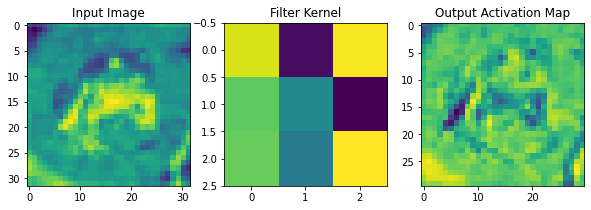

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


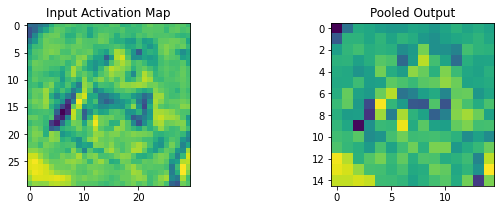

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


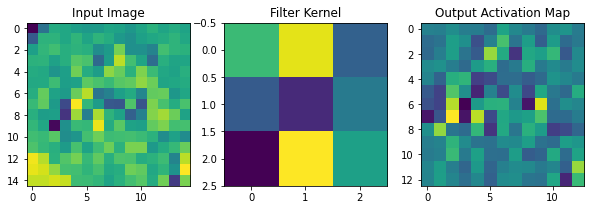

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


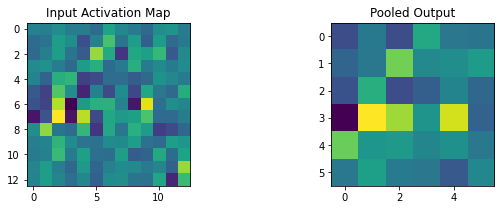

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5958, 0.5958, 0.5958, 0.5958, 0.5958, 0.5958, 0.5958, 0.5958])
MLP output without softmax :  tensor([-0.7504, -2.2131,  1.4486, -1.9907, -1.2832,  1.5588,  2.3113,  3.8842,
         0.5963,  0.7794])
MLP output with softmax :  tensor([0.0065, 0.0015, 0.0585, 0.0019, 0.0038, 0.0654, 0.1387, 0.6687, 0.0250,
        0.0300])


Output vector for class (6,):
tensor([0.0065, 0.0015, 0.0585, 0.0019, 0.0038, 0.0654, 0.1387, 0.6687, 0.0250,
        0.0300])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


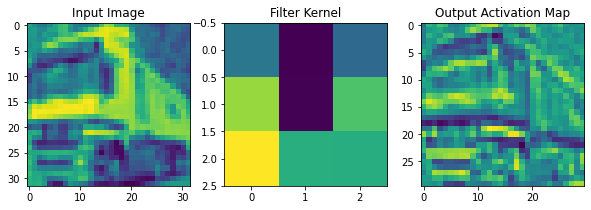

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


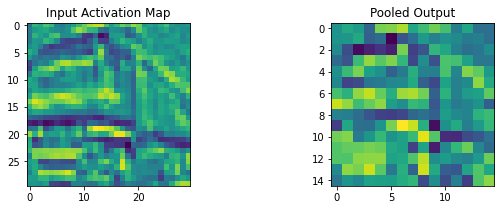

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


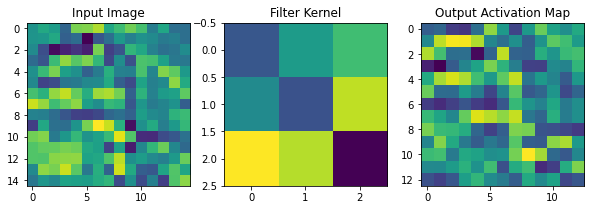

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


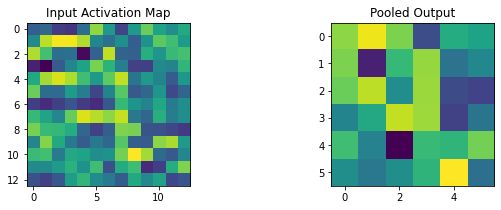

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7026, 0.7026, 0.7026, 0.7026, 0.7026, 0.7026, 0.7026, 0.7026])
MLP output without softmax :  tensor([-1.3147,  4.2959,  0.6126, -3.0817, -0.3444,  2.7262,  1.8617, -1.9687,
        -2.3169, -1.3105])
MLP output with softmax :  tensor([2.7269e-03, 7.4529e-01, 1.8736e-02, 4.6588e-04, 7.1955e-03, 1.5510e-01,
        6.5335e-02, 1.4178e-03, 1.0010e-03, 2.7384e-03])


Output vector for class (9,):
tensor([2.7269e-03, 7.4529e-01, 1.8736e-02, 4.6588e-04, 7.1955e-03, 1.5510e-01,
        6.5335e-02, 1.4178e-03, 1.0010e-03, 2.7384e-03])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


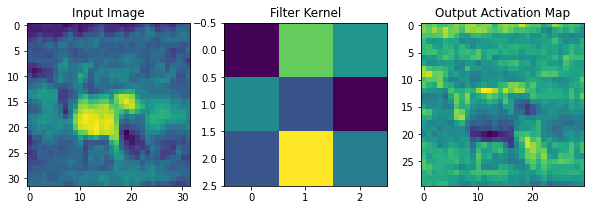

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


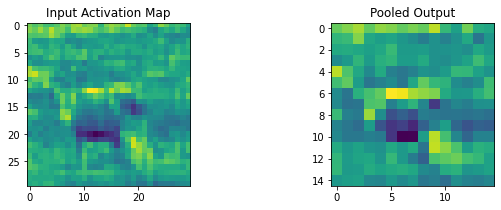

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


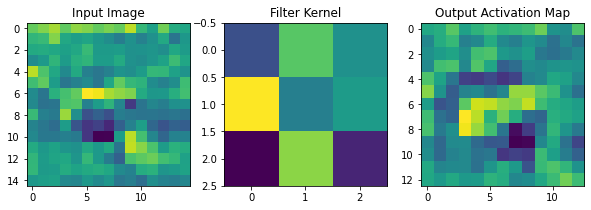

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


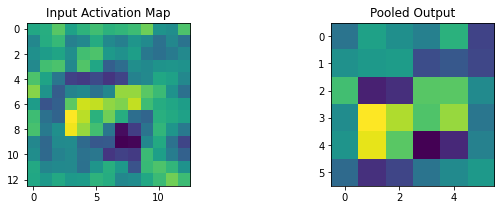

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6397, 0.6397, 0.6397, 0.6397, 0.6397, 0.6397, 0.6397, 0.6397])
MLP output without softmax :  tensor([-2.8705, -3.3855, -2.2670, -0.0935, -0.4316,  0.8411,  2.4163,  1.1563,
        -2.3330, -0.8958])
MLP output with softmax :  tensor([0.0030, 0.0018, 0.0055, 0.0480, 0.0343, 0.1223, 0.5909, 0.1676, 0.0051,
        0.0215])


Output vector for class (4,):
tensor([0.0030, 0.0018, 0.0055, 0.0480, 0.0343, 0.1223, 0.5909, 0.1676, 0.0051,
        0.0215])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


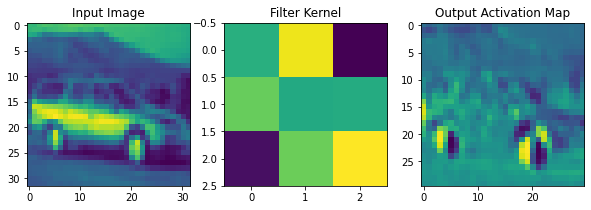

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


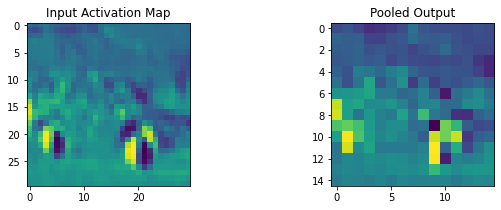

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


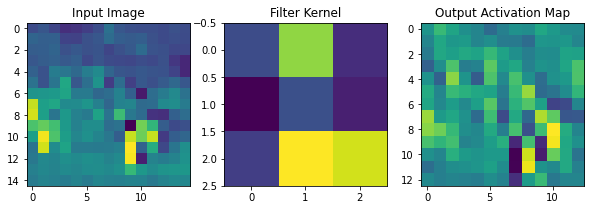

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


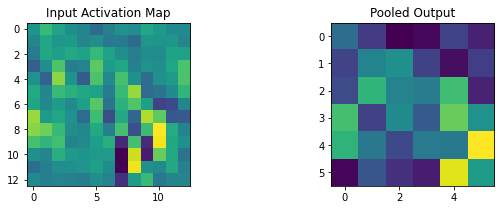

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718])
MLP output without softmax :  tensor([-0.4257, -0.8678,  0.1409,  0.1688,  1.3579,  5.5479,  0.9602, -0.5169,
        -0.6826, -2.1184])
MLP output with softmax :  tensor([2.4392e-03, 1.5677e-03, 4.2987e-03, 4.4201e-03, 1.4517e-02, 9.5844e-01,
        9.7531e-03, 2.2267e-03, 1.8866e-03, 4.4890e-04])


Output vector for class (1,):
tensor([2.4392e-03, 1.5677e-03, 4.2987e-03, 4.4201e-03, 1.4517e-02, 9.5844e-01,
        9.7531e-03, 2.2267e-03, 1.8866e-03, 4.4890e-04])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


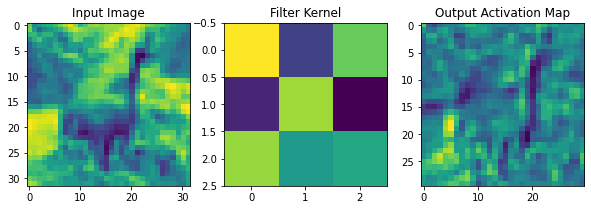

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


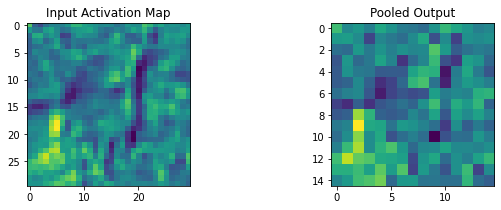

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


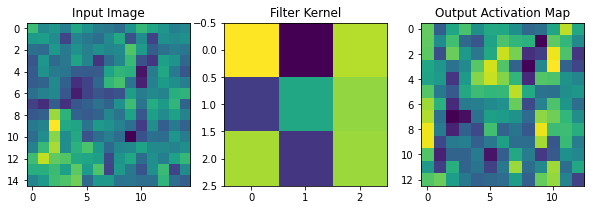

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


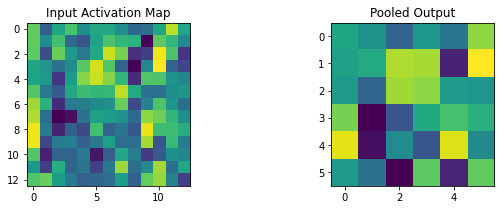

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7024, 0.7024, 0.7024, 0.7024, 0.7024, 0.7024, 0.7024, 0.7024])
MLP output without softmax :  tensor([ 0.3357,  2.4128, -4.8394,  0.2773, -1.0694,  1.3716,  0.8559,  0.3692,
        -0.1979,  1.7185])
MLP output with softmax :  tensor([4.9302e-02, 3.9352e-01, 2.7886e-04, 4.6507e-02, 1.2096e-02, 1.3892e-01,
        8.2949e-02, 5.0983e-02, 2.8918e-02, 1.9653e-01])


Output vector for class (2,):
tensor([4.9302e-02, 3.9352e-01, 2.7886e-04, 4.6507e-02, 1.2096e-02, 1.3892e-01,
        8.2949e-02, 5.0983e-02, 2.8918e-02, 1.9653e-01])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


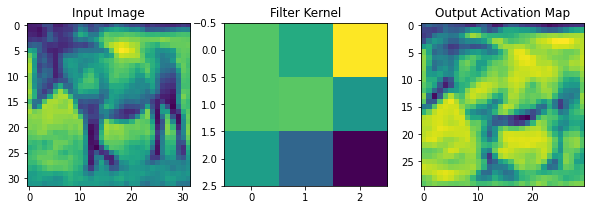

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


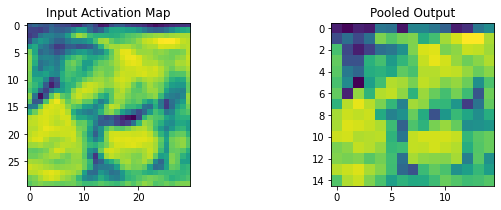

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


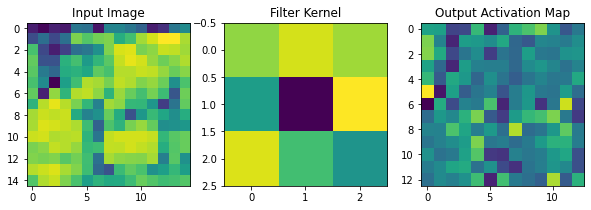

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


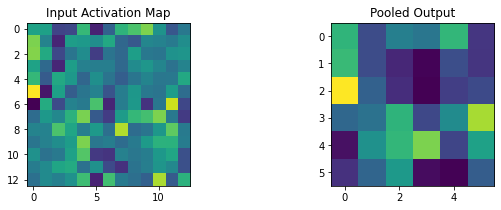

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6458, 0.6458, 0.6458, 0.6458, 0.6458, 0.6458, 0.6458, 0.6458])
MLP output without softmax :  tensor([-0.3967, -0.9239,  1.6336, -1.8657, -2.9478,  3.2827,  0.6520,  0.1171,
         1.1734, -2.8683])
MLP output with softmax :  tensor([0.0171, 0.0101, 0.1301, 0.0039, 0.0013, 0.6767, 0.0487, 0.0285, 0.0821,
        0.0014])


Output vector for class (7,):
tensor([0.0171, 0.0101, 0.1301, 0.0039, 0.0013, 0.6767, 0.0487, 0.0285, 0.0821,
        0.0014])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


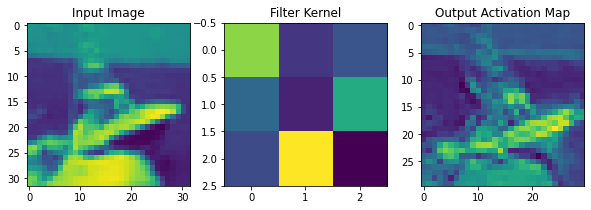

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


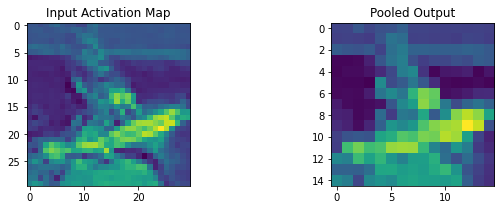

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


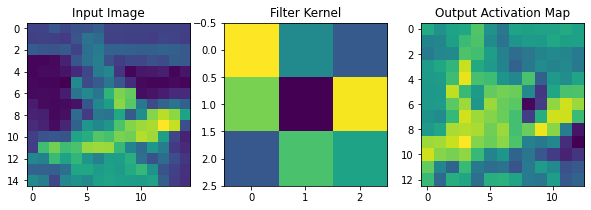

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


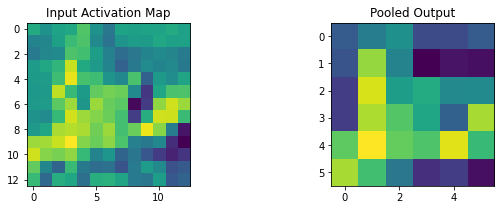

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6640, 0.6640, 0.6640, 0.6640, 0.6640, 0.6640, 0.6640, 0.6640])
MLP output without softmax :  tensor([-0.7248, -2.2868,  4.0280, -4.3700, -0.0807,  0.3385, -0.4287, -3.4764,
         3.9710, -3.1968])
MLP output with softmax :  tensor([4.2933e-03, 9.0038e-04, 4.9764e-01, 1.1213e-04, 8.1757e-03, 1.2433e-02,
        5.7729e-03, 2.7403e-04, 4.7004e-01, 3.6244e-04])


Output vector for class (8,):
tensor([4.2933e-03, 9.0038e-04, 4.9764e-01, 1.1213e-04, 8.1757e-03, 1.2433e-02,
        5.7729e-03, 2.7403e-04, 4.7004e-01, 3.6244e-04])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


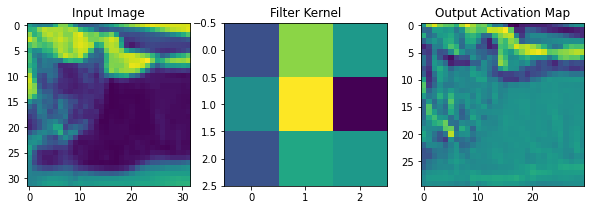

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


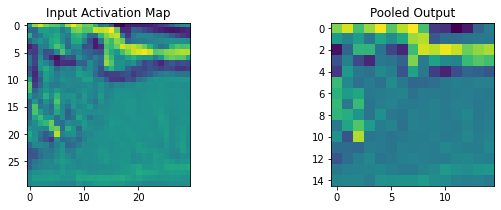

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


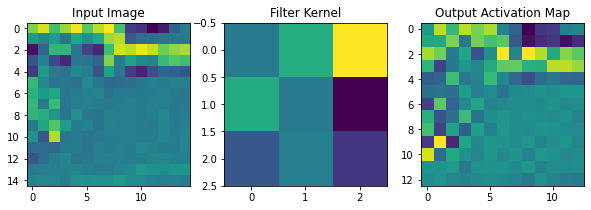

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


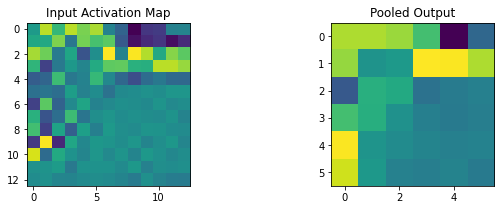

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6274, 0.6274, 0.6274, 0.6274, 0.6274, 0.6274, 0.6274, 0.6274])
MLP output without softmax :  tensor([ 1.0127,  0.8014,  1.0274, -2.7477, -0.9406,  2.0799, -0.5404, -0.3761,
         0.4851, -0.5786])
MLP output with softmax :  tensor([0.1398, 0.1132, 0.1419, 0.0033, 0.0198, 0.4065, 0.0296, 0.0349, 0.0825,
        0.0285])


Output vector for class (3,):
tensor([0.1398, 0.1132, 0.1419, 0.0033, 0.0198, 0.4065, 0.0296, 0.0349, 0.0825,
        0.0285])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


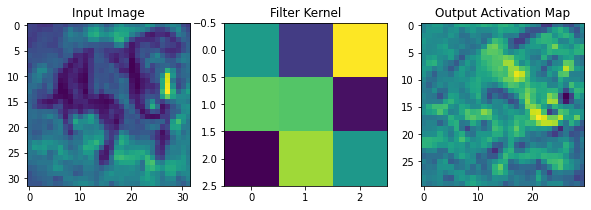

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


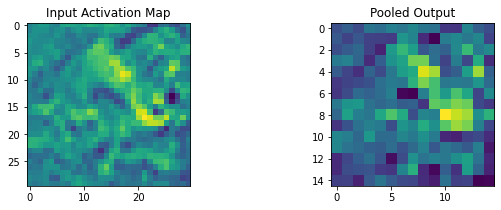

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


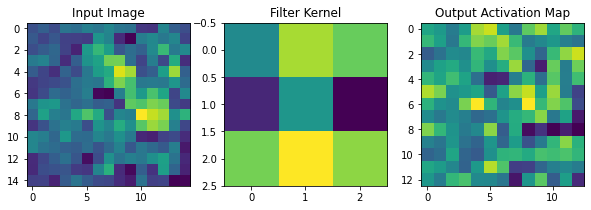

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


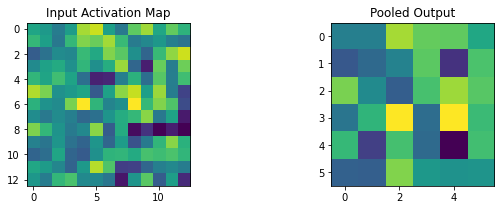

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6728, 0.6728, 0.6728, 0.6728, 0.6728, 0.6728, 0.6728, 0.6728])
MLP output without softmax :  tensor([ 5.4845,  0.3592,  0.3178, -0.2411, -0.0269,  0.6639,  0.7616, -1.2325,
         1.5052, -0.2225])
MLP output with softmax :  tensor([0.9442, 0.0056, 0.0054, 0.0031, 0.0038, 0.0076, 0.0084, 0.0011, 0.0177,
        0.0031])


Output vector for class (5,):
tensor([0.9442, 0.0056, 0.0054, 0.0031, 0.0038, 0.0076, 0.0084, 0.0011, 0.0177,
        0.0031])
**********************************************************************************************************
Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


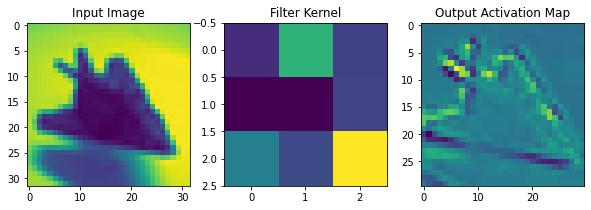

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


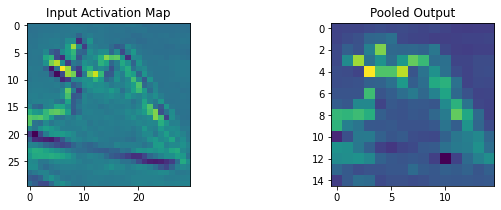

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


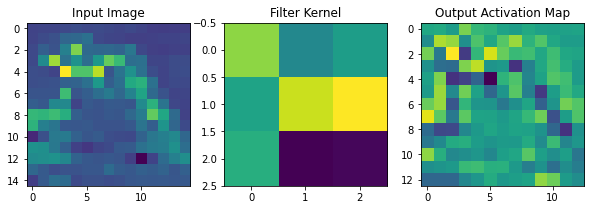

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


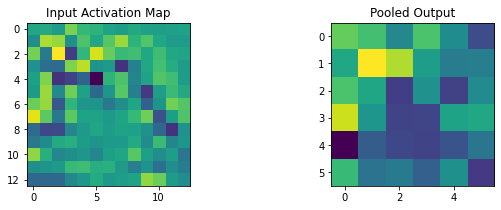

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6217, 0.6217, 0.6217, 0.6217, 0.6217, 0.6217, 0.6217, 0.6217])
MLP output without softmax :  tensor([ 0.2279, -1.1130, -1.5510,  1.6473, -1.0546,  3.7549, -0.4972, -0.1736,
        -0.1801, -1.0104])
MLP output with softmax :  tensor([0.0238, 0.0062, 0.0040, 0.0985, 0.0066, 0.8106, 0.0115, 0.0159, 0.0158,
        0.0069])


Output vector for class (0,):
tensor([0.0238, 0.0062, 0.0040, 0.0985, 0.0066, 0.8106, 0.0115, 0.0159, 0.0158,
        0.0069])
**********************************************************************************************************


In [18]:
# Create an empty dictionary to store the first image from each class
X_train_first = {}

# Iterate over each class
for key in map:
    # Take only the first image of the class
    X_train_first[key] = train_X[map[key][0]]

# Pass each image through the model and display the output vector
for key in X_train_first:
    # Get the image from the dictionary
    img = X_train_first[key]
    
    # Pass the image through the model
    output, pool_map2, GAP_pool_map = feed_forward_path(img)
    
    # Print the output vector for the class
    print(f"Output vector for class {key}:")
    print(output)
    print("**********************************************************************************************************")


**Answer** : 
No trend is observed in the output vector as we are using random filter and the model is not learning.

**8(b)** Does a randomly initialized network show any discriminability? Visualize (plot) the bottleneck
layer (output of flattening layer) using PCA (builtin function) in 2D. Choose three images per class
from CIFAR-10. (3) 

In [19]:
# Extract first three images and labels for each class
X_train_first3 = []
y_train_first3 = []

# Loop through each class label
for key in map:
    # Extend (add multiple images at a time) the first three images of the current class to the list of images
    X_train_first3.extend(train_X[map[key][:3]])

    # Extend the current class label three times to the list of labels
    y_train_first3.extend([key]*3)

# Convert the lists to PyTorch tensors
X_train_first3 = torch.tensor(X_train_first3)
y_train_first3 = torch.tensor(y_train_first3)

# Print the shapes of the tensors
print(X_train_first3.shape, y_train_first3.shape)

torch.Size([30, 32, 32, 3]) torch.Size([30, 1])


<ipython-input-19-1c4b77d4a735>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X_train_first3 = torch.tensor(X_train_first3)


  The bottleneck layer is an essential part of a convolutional neural network that comes after feature extraction and before the output layer. Its main function is to convert the high-level features learned from the convolutional layers into a format that can be used for classification or regression. One way to evaluate the bottleneck layer's ability to distinguish between different image classes is to use dimensionality reduction techniques such as PCA to visualize the bottleneck layer outputs in 2D space. 
  
  If the different image classes are well separated in the 2D space, it suggests that the bottleneck layer can learn features that distinguish between them. In other words, if the bottleneck layer can capture the most critical features of the images responsible for differentiating one class from another, the bottleneck layer outputs can segregate different classes in the 2D space. **The better the separation, the better the bottleneck layer can distinguish between various image classes.**

Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


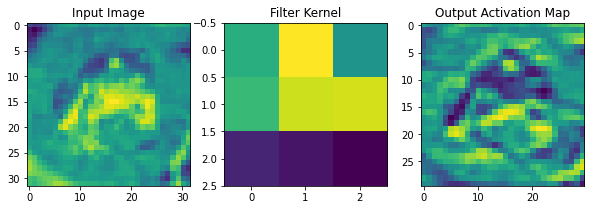

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


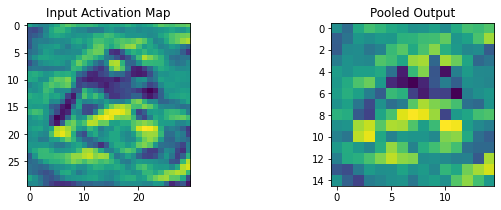

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


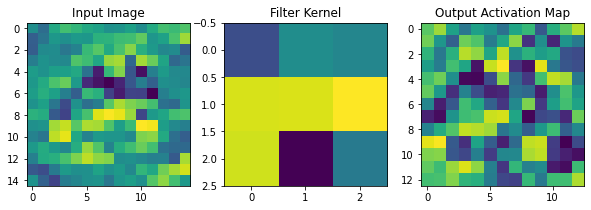

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


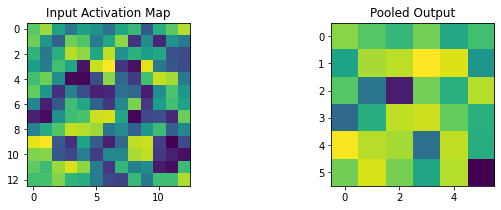

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7509, 0.7509, 0.7509, 0.7509, 0.7509, 0.7509, 0.7509, 0.7509])
MLP output without softmax :  tensor([ 1.6475,  0.0849,  5.1633, -1.2527, -0.3404,  2.3758,  4.3055,  2.3385,
        -2.5709, -1.1254])
MLP output with softmax :  tensor([1.8707e-02, 3.9205e-03, 6.2935e-01, 1.0291e-03, 2.5624e-03, 3.8753e-02,
        2.6691e-01, 3.7332e-02, 2.7541e-04, 1.1688e-03])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


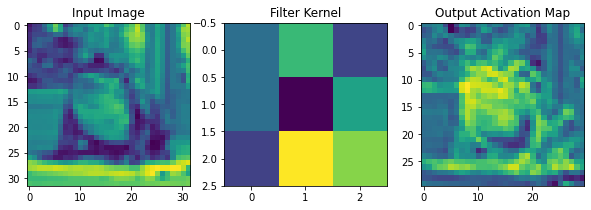

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


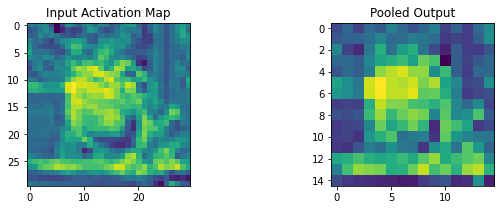

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


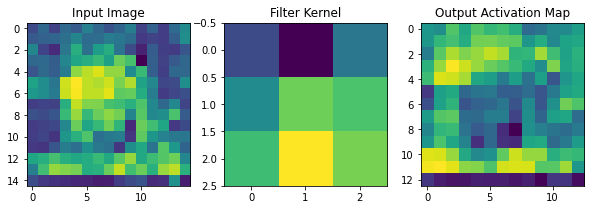

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


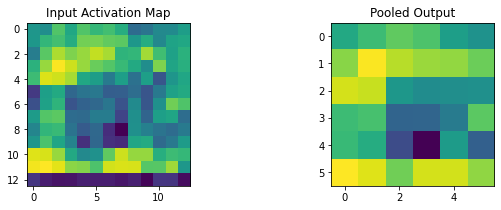

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6400, 0.6400, 0.6400, 0.6400, 0.6400, 0.6400, 0.6400, 0.6400])
MLP output without softmax :  tensor([ 1.7482, -0.7828, -1.9821,  1.2888, -0.7969,  0.7870, -1.5050, -2.3644,
         1.7252,  0.3775])
MLP output with softmax :  tensor([0.2872, 0.0229, 0.0069, 0.1814, 0.0225, 0.1098, 0.0111, 0.0047, 0.2806,
        0.0729])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


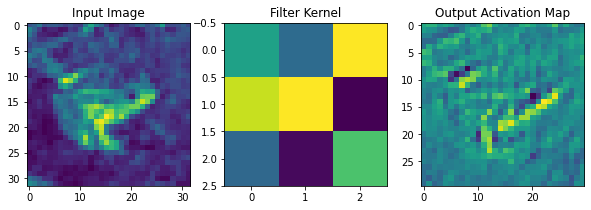

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


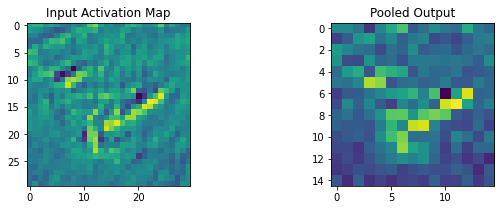

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


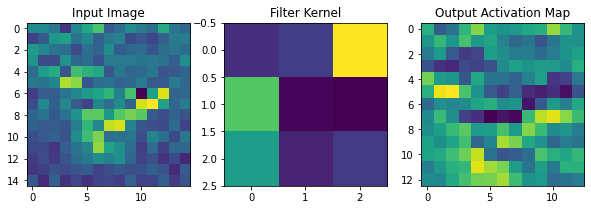

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


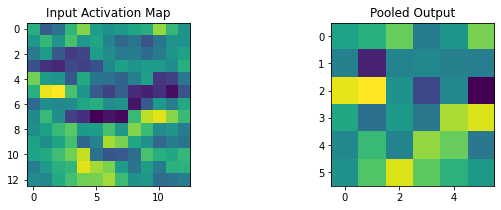

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064])
MLP output without softmax :  tensor([ 2.4521,  1.9589,  2.2290, -1.9856, -2.1413,  2.4284,  1.8566, -1.6819,
        -1.4591,  0.8403])
MLP output with softmax :  tensor([0.2383, 0.1455, 0.1907, 0.0028, 0.0024, 0.2327, 0.1314, 0.0038, 0.0048,
        0.0476])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


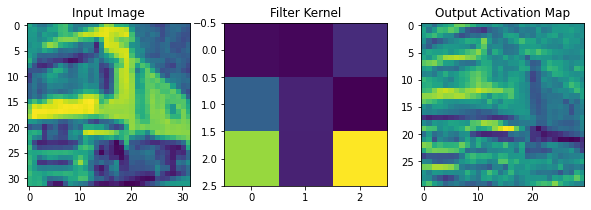

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


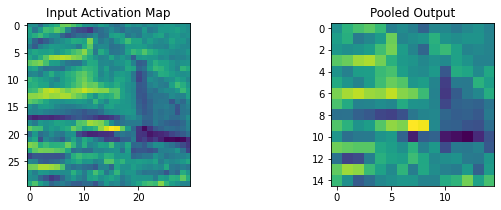

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


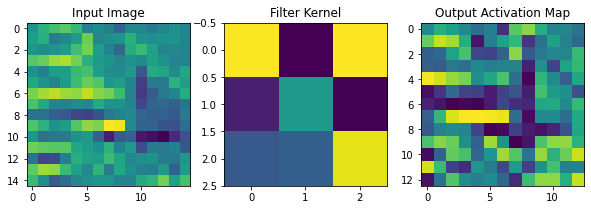

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


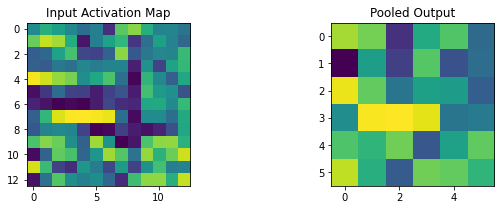

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7149, 0.7149, 0.7149, 0.7149, 0.7149, 0.7149, 0.7149, 0.7149])
MLP output without softmax :  tensor([-1.6973, -2.8482, -1.9253,  1.6041, -3.1560,  2.9995, -1.2080, -0.9766,
        -1.0240, -0.4123])
MLP output with softmax :  tensor([0.0067, 0.0021, 0.0054, 0.1830, 0.0016, 0.7388, 0.0110, 0.0139, 0.0132,
        0.0244])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


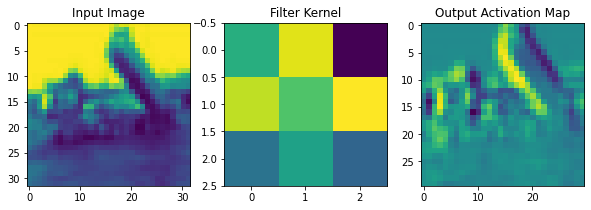

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


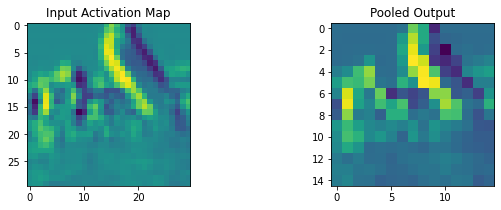

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


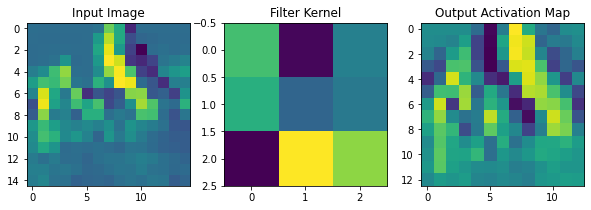

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


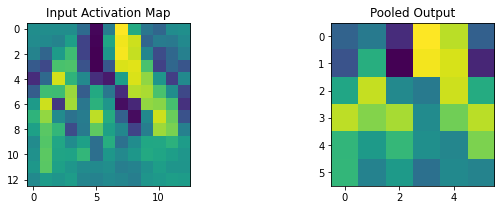

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6886, 0.6886, 0.6886, 0.6886, 0.6886, 0.6886, 0.6886, 0.6886])
MLP output without softmax :  tensor([ 3.0814,  3.2284,  1.2580, -0.1716,  1.4426,  1.6086,  0.6879,  2.0808,
         0.0447, -4.5355])
MLP output with softmax :  tensor([3.0401e-01, 3.5214e-01, 4.9091e-02, 1.1752e-02, 5.9040e-02, 6.9702e-02,
        2.7759e-02, 1.1177e-01, 1.4590e-02, 1.4959e-04])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


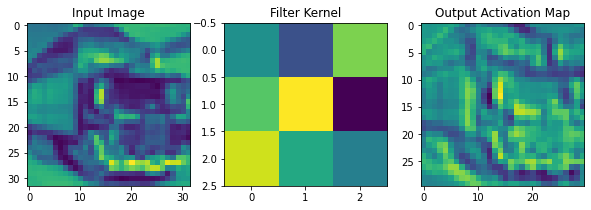

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


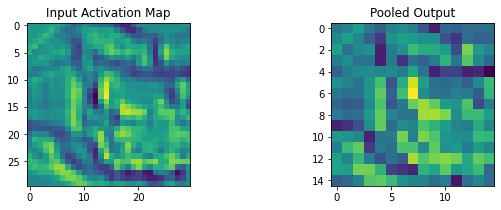

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


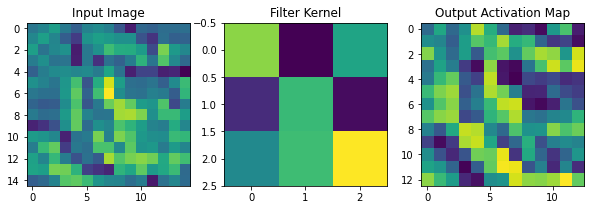

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


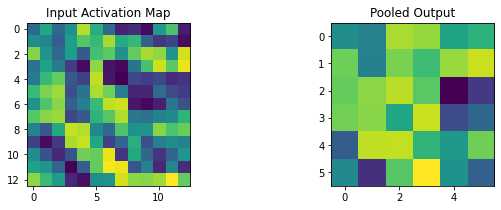

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6923, 0.6923, 0.6923, 0.6923, 0.6923, 0.6923, 0.6923, 0.6923])
MLP output without softmax :  tensor([ 0.8224, -0.9037,  0.5895,  2.1591, -3.3370,  0.8754, -2.5096,  0.0139,
         2.9801,  3.3432])
MLP output with softmax :  tensor([0.0352, 0.0063, 0.0279, 0.1339, 0.0005, 0.0371, 0.0013, 0.0157, 0.3044,
        0.4377])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


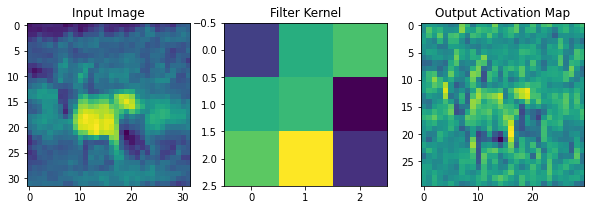

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


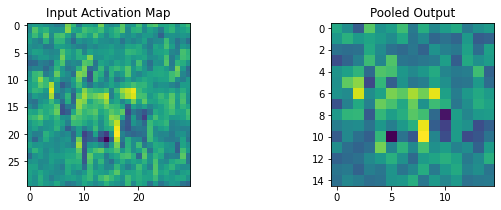

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


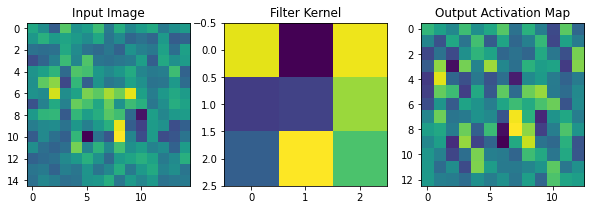

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


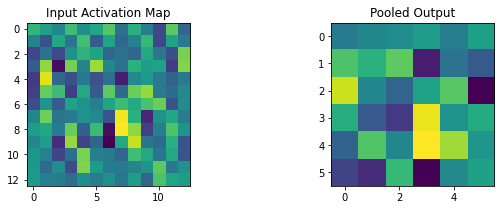

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6883, 0.6883, 0.6883, 0.6883, 0.6883, 0.6883, 0.6883, 0.6883])
MLP output without softmax :  tensor([ 1.0436, -2.5555,  0.4784, -3.3427,  2.0555, -1.4651,  1.9631,  0.6679,
         0.5388, -0.7858])
MLP output with softmax :  tensor([0.1191, 0.0033, 0.0677, 0.0015, 0.3275, 0.0097, 0.2986, 0.0818, 0.0719,
        0.0191])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


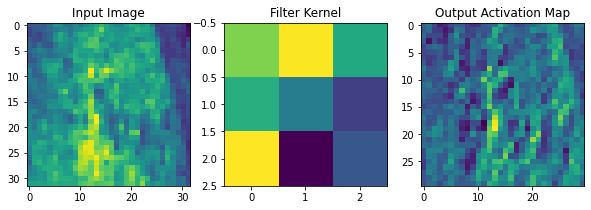

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


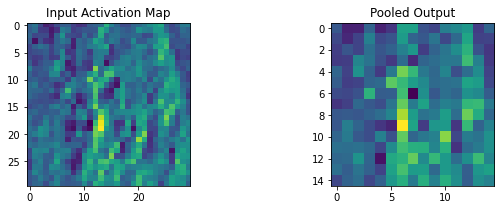

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


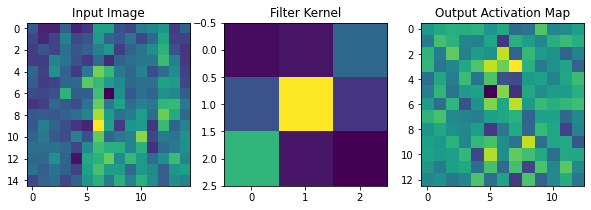

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


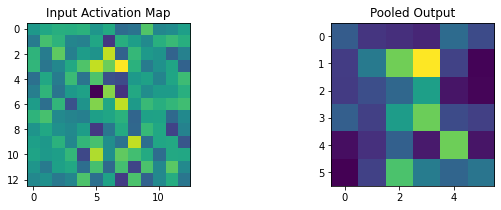

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5719, 0.5719, 0.5719, 0.5719, 0.5719, 0.5719, 0.5719, 0.5719])
MLP output without softmax :  tensor([ 2.6114, -0.2522, -2.3982,  0.5410, -2.8662, -0.2485,  2.1711, -1.0950,
        -0.3729, -4.2665])
MLP output with softmax :  tensor([0.5073, 0.0289, 0.0034, 0.0640, 0.0021, 0.0291, 0.3266, 0.0125, 0.0257,
        0.0005])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


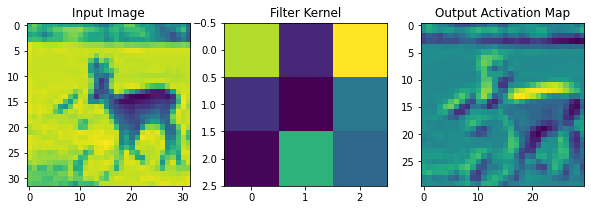

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


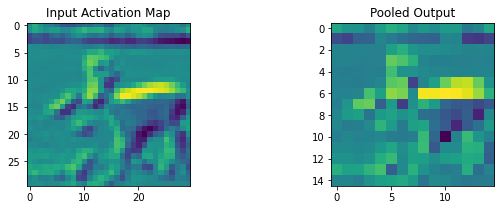

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


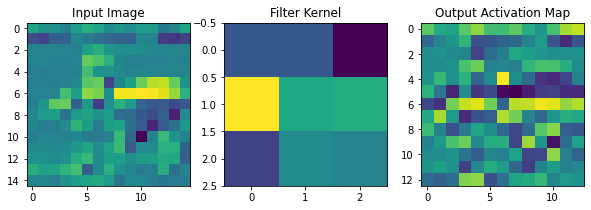

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


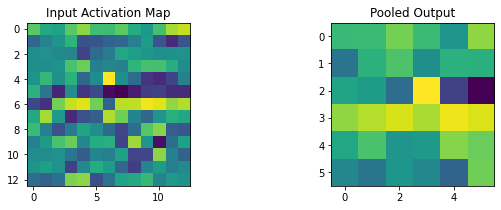

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6789, 0.6789, 0.6789, 0.6789, 0.6789, 0.6789, 0.6789, 0.6789])
MLP output without softmax :  tensor([ 0.3444, -2.5206, -0.2146,  0.3949, -0.2298, -1.3029,  2.3556,  0.8301,
         1.7861, -1.4899])
MLP output with softmax :  tensor([0.0591, 0.0034, 0.0338, 0.0622, 0.0333, 0.0114, 0.4416, 0.0960, 0.2498,
        0.0094])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


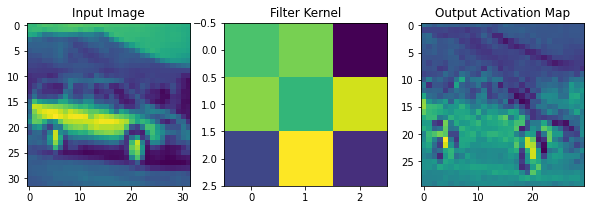

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


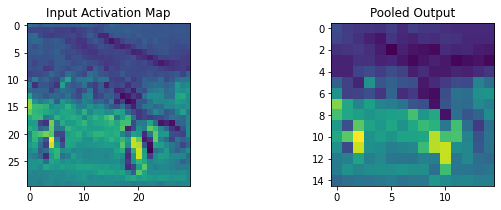

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


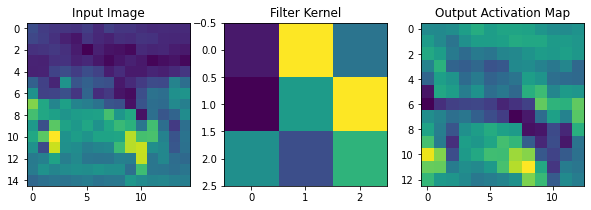

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


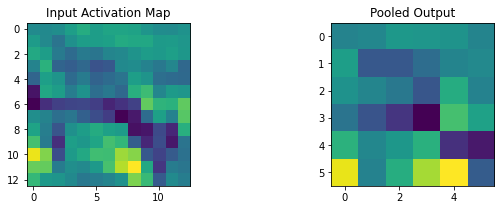

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436, 0.5436])
MLP output without softmax :  tensor([-0.8914,  0.3386, -0.8664, -2.3183,  3.9008,  2.4225, -0.2345,  2.2975,
        -0.2239,  2.6149])
MLP output with softmax :  tensor([0.0046, 0.0159, 0.0048, 0.0011, 0.5602, 0.1277, 0.0090, 0.1127, 0.0091,
        0.1549])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


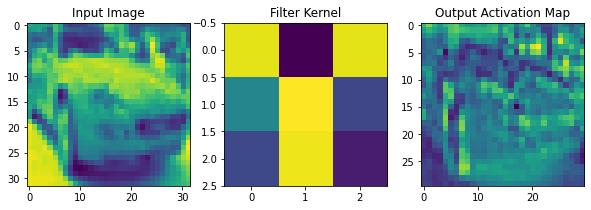

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


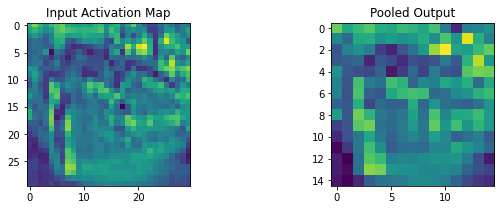

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


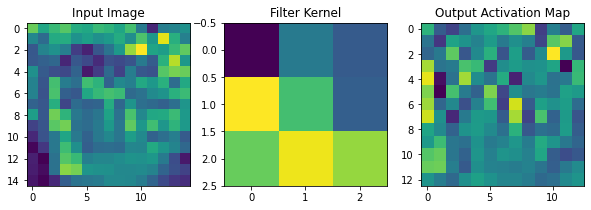

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


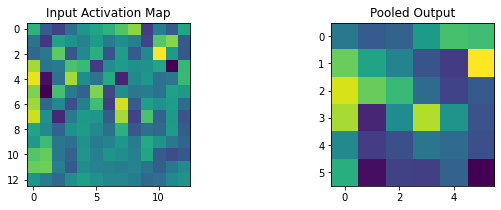

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6350, 0.6350, 0.6350, 0.6350, 0.6350, 0.6350, 0.6350, 0.6350])
MLP output without softmax :  tensor([ 2.4902,  0.4217, -2.4789, -1.0094, -0.2453, -2.1683,  2.5259, -0.4397,
        -0.1100, -0.9788])
MLP output with softmax :  tensor([0.4110, 0.0519, 0.0029, 0.0124, 0.0267, 0.0039, 0.4260, 0.0219, 0.0305,
        0.0128])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


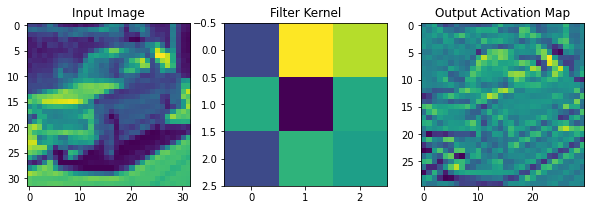

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


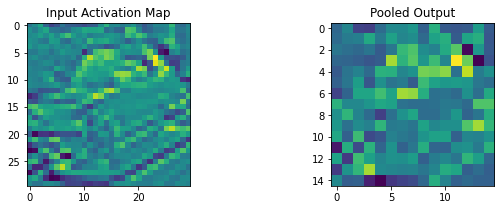

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


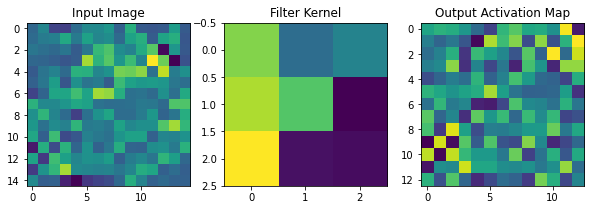

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


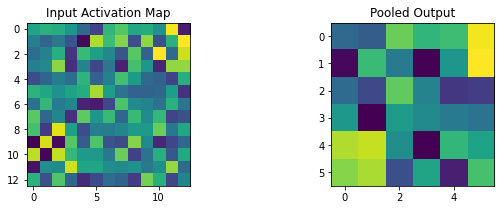

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7175, 0.7175, 0.7175, 0.7175, 0.7175, 0.7175, 0.7175, 0.7175])
MLP output without softmax :  tensor([ 0.9241,  2.6367, -0.1535,  0.1102,  3.9719, -1.5678,  2.7193, -5.5806,
         0.1254,  1.3802])
MLP output with softmax :  tensor([2.7377e-02, 1.5176e-01, 9.3196e-03, 1.2131e-02, 5.7677e-01, 2.2655e-03,
        1.6482e-01, 4.0966e-05, 1.2317e-02, 4.3199e-02])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


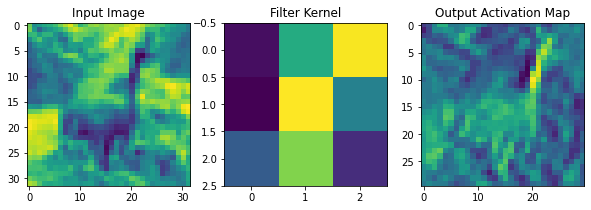

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


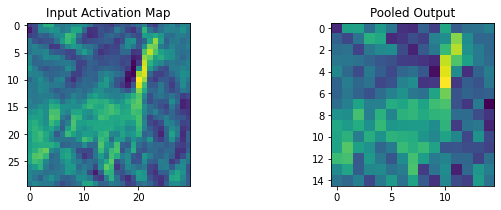

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


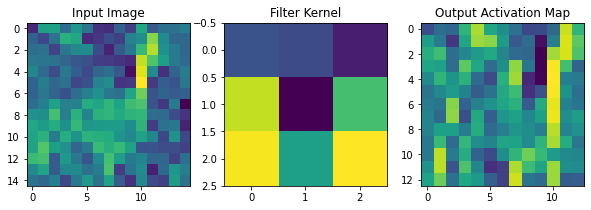

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


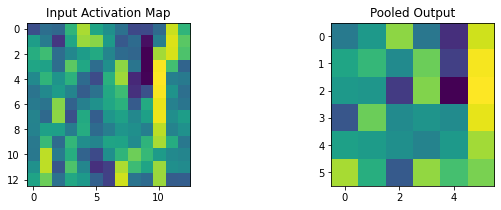

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6840, 0.6840, 0.6840, 0.6840, 0.6840, 0.6840, 0.6840, 0.6840])
MLP output without softmax :  tensor([-1.4566,  0.3721,  1.4833,  2.8018,  0.6821, -0.7046,  3.3499, -1.5696,
         2.7191,  3.3934])
MLP output with softmax :  tensor([0.0024, 0.0147, 0.0447, 0.1669, 0.0200, 0.0050, 0.2888, 0.0021, 0.1537,
        0.3017])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


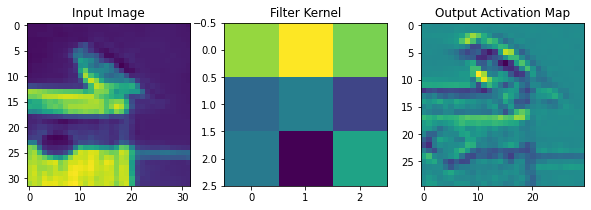

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


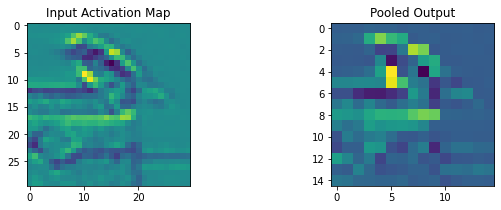

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


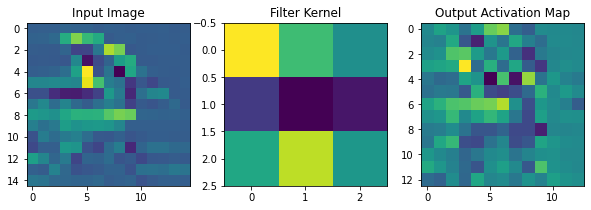

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


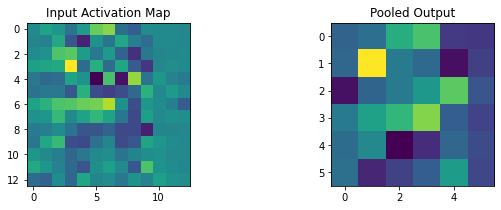

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5918, 0.5918, 0.5918, 0.5918, 0.5918, 0.5918, 0.5918, 0.5918])
MLP output without softmax :  tensor([ 2.3099,  1.9776, -0.8807, -1.9616,  0.2194,  0.9754, -0.4413, -3.9490,
         1.5258,  1.5004])
MLP output with softmax :  tensor([0.3198, 0.2294, 0.0132, 0.0045, 0.0395, 0.0842, 0.0204, 0.0006, 0.1460,
        0.1423])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


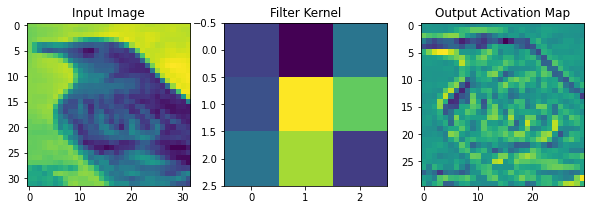

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


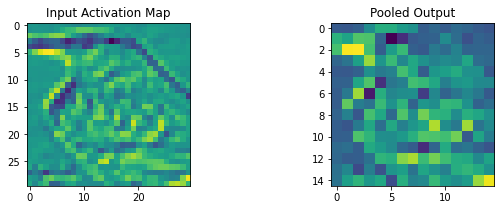

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


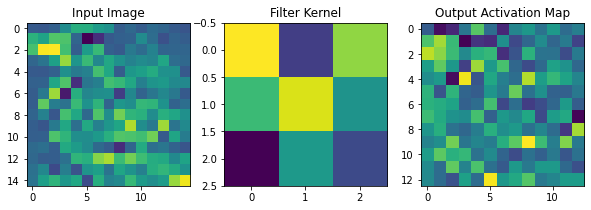

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


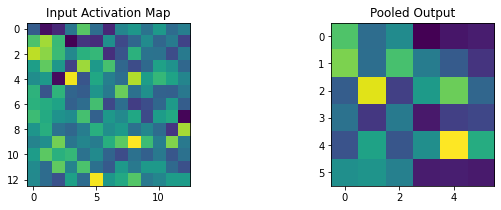

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5784, 0.5784, 0.5784, 0.5784, 0.5784, 0.5784, 0.5784, 0.5784])
MLP output without softmax :  tensor([-1.9862,  1.7286,  3.8572, -0.4002,  0.6837, -0.0593, -2.7702, -0.9783,
         0.3102, -0.0262])
MLP output with softmax :  tensor([0.0023, 0.0947, 0.7959, 0.0113, 0.0333, 0.0158, 0.0011, 0.0063, 0.0229,
        0.0164])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


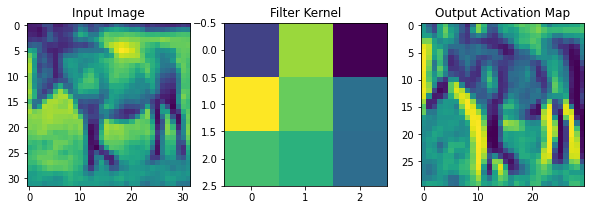

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


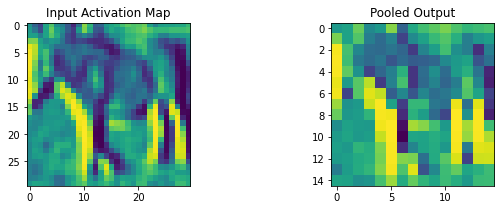

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


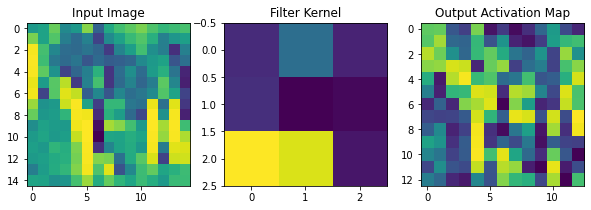

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


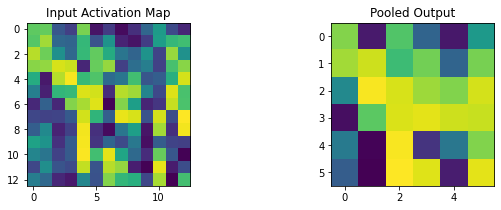

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7362, 0.7362, 0.7362, 0.7362, 0.7362, 0.7362, 0.7362, 0.7362])
MLP output without softmax :  tensor([ 0.1220, -3.0211,  0.2005,  1.0363,  1.6241, -4.1997, -0.3927, -0.6214,
         0.1072,  0.1097])
MLP output with softmax :  tensor([0.0822, 0.0035, 0.0889, 0.2050, 0.3690, 0.0011, 0.0491, 0.0391, 0.0810,
        0.0812])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


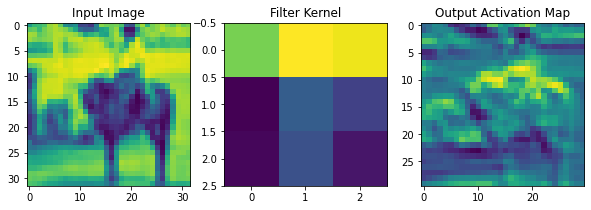

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


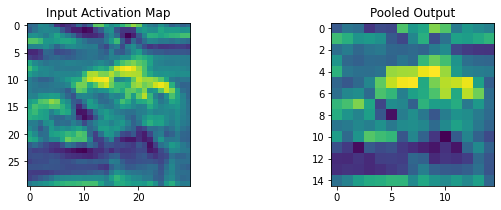

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


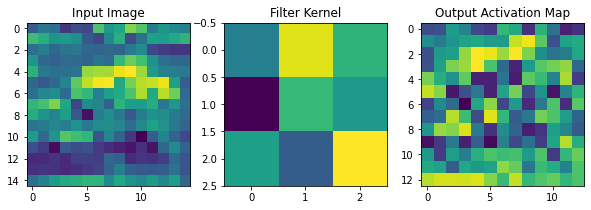

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


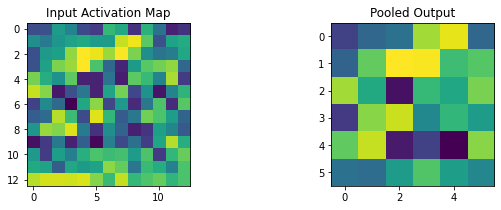

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6995, 0.6995, 0.6995, 0.6995, 0.6995, 0.6995, 0.6995, 0.6995])
MLP output without softmax :  tensor([-0.3442,  2.6227, -0.4275,  1.2066, -2.2912,  2.0797,  0.4810, -0.4432,
        -2.1644,  1.9862])
MLP output with softmax :  tensor([0.0196, 0.3800, 0.0180, 0.0922, 0.0028, 0.2208, 0.0446, 0.0177, 0.0032,
        0.2011])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


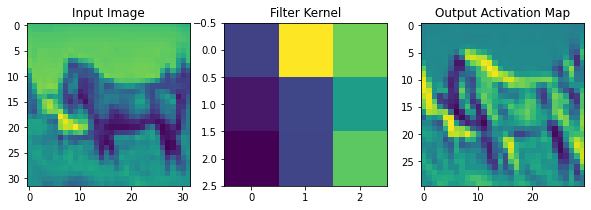

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


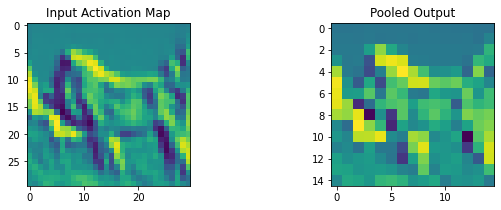

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


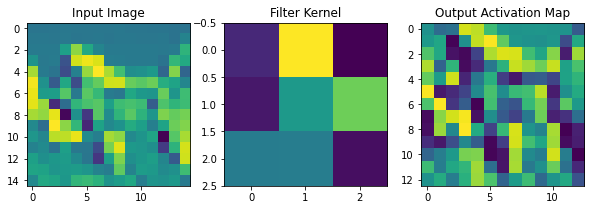

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


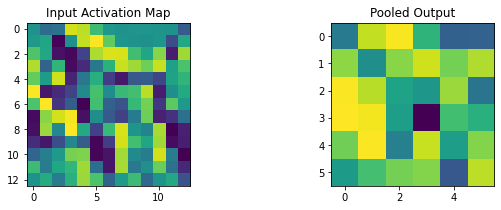

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.7878, 0.7878, 0.7878, 0.7878, 0.7878, 0.7878, 0.7878, 0.7878])
MLP output without softmax :  tensor([-2.0659, -2.6726,  3.3881, -1.6087, -3.7776,  0.7533,  0.4618, -1.0405,
         5.7673,  1.2857])
MLP output with softmax :  tensor([3.5451e-04, 1.9328e-04, 8.2852e-02, 5.6001e-04, 6.4014e-05, 5.9430e-03,
        4.4402e-03, 9.8851e-04, 8.9448e-01, 1.0121e-02])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


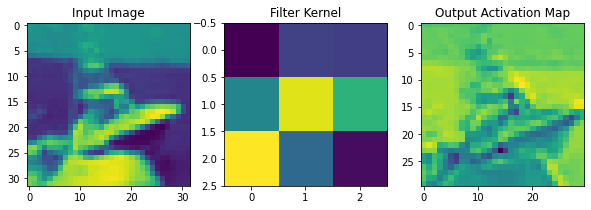

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


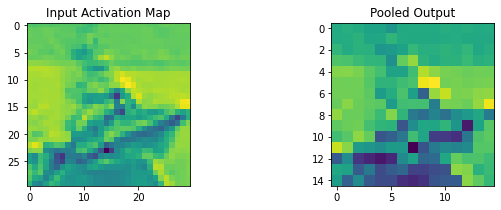

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


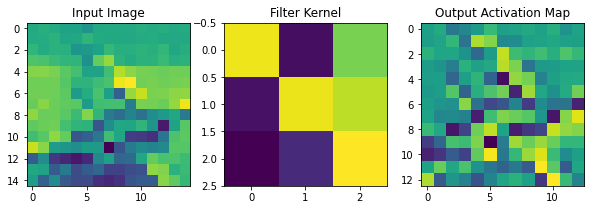

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


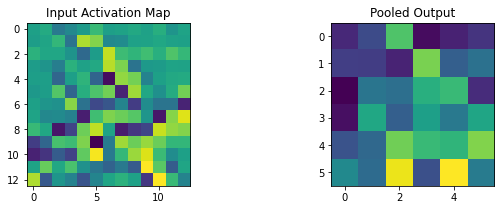

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6539, 0.6539, 0.6539, 0.6539, 0.6539, 0.6539, 0.6539, 0.6539])
MLP output without softmax :  tensor([-1.4708e+00, -1.1201e+00,  9.1872e-01, -1.8739e+00, -6.5998e-01,
         1.9963e+00,  2.9191e-01, -1.0026e+00,  3.4822e-01, -1.3853e-03])
MLP output with softmax :  tensor([0.0151, 0.0214, 0.1647, 0.0101, 0.0340, 0.4838, 0.0880, 0.0241, 0.0931,
        0.0656])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


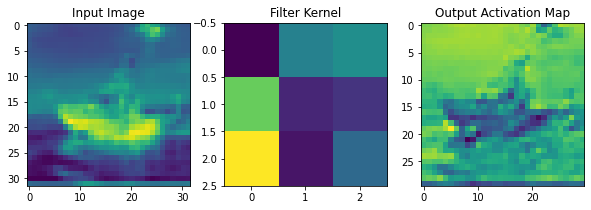

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


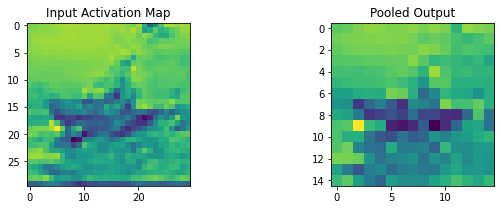

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


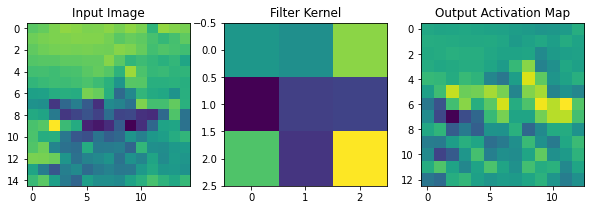

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


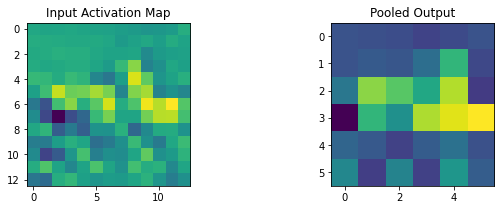

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5657, 0.5657, 0.5657, 0.5657, 0.5657, 0.5657, 0.5657, 0.5657])
MLP output without softmax :  tensor([ 0.4356,  0.6055,  2.3021,  1.4290, -1.7699, -0.4496,  0.2217, -0.7641,
        -3.5331, -2.4480])
MLP output with softmax :  tensor([0.0766, 0.0908, 0.4952, 0.2068, 0.0084, 0.0316, 0.0618, 0.0231, 0.0014,
        0.0043])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


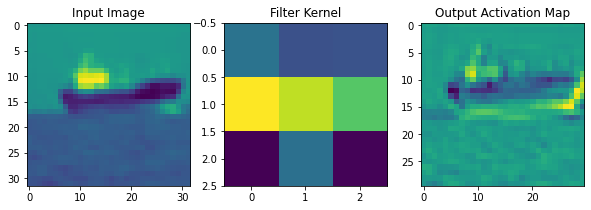

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


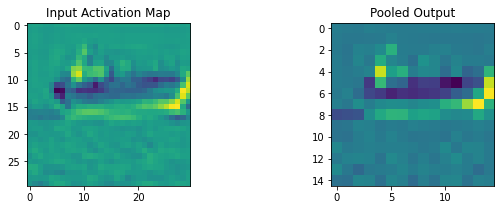

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


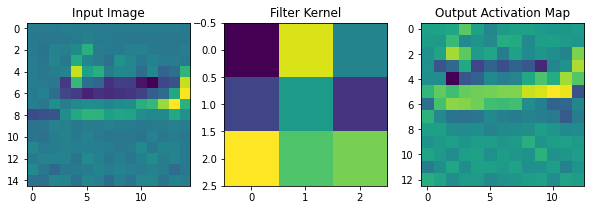

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


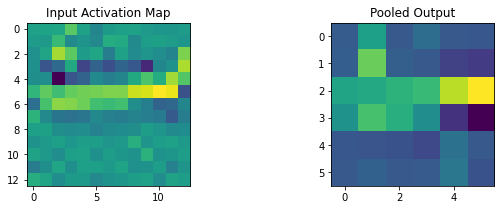

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5578, 0.5578, 0.5578, 0.5578, 0.5578, 0.5578, 0.5578, 0.5578])
MLP output without softmax :  tensor([ 1.8061, -1.6289,  3.4006,  0.9128,  3.2236, -0.6861, -3.0345,  1.7158,
        -2.3411,  0.3764])
MLP output with softmax :  tensor([0.0851, 0.0027, 0.4191, 0.0348, 0.3511, 0.0070, 0.0007, 0.0777, 0.0013,
        0.0204])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


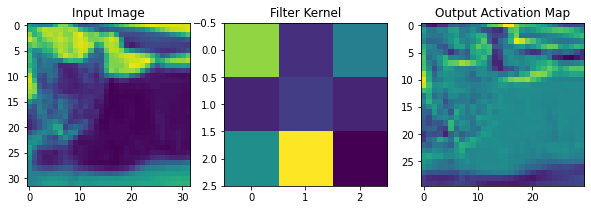

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


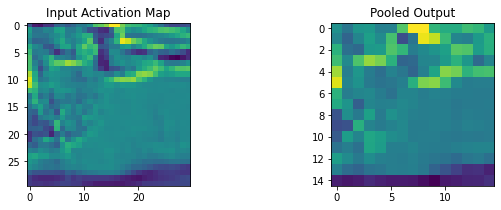

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


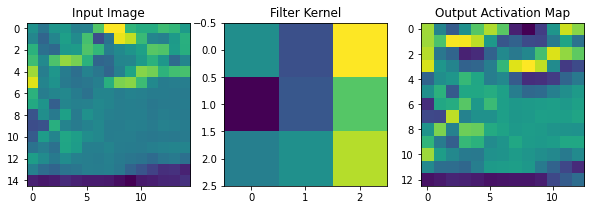

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


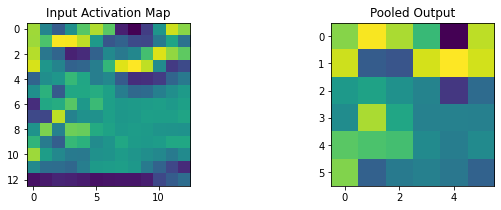

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5917, 0.5917, 0.5917, 0.5917, 0.5917, 0.5917, 0.5917, 0.5917])
MLP output without softmax :  tensor([-1.1369,  3.7645,  0.7820,  3.3743, -4.2086, -0.0144, -1.1770,  0.1690,
        -1.8255,  1.4861])
MLP output with softmax :  tensor([3.9158e-03, 5.2660e-01, 2.6680e-02, 3.5646e-01, 1.8146e-04, 1.2031e-02,
        3.7619e-03, 1.4454e-02, 1.9669e-03, 5.3949e-02])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


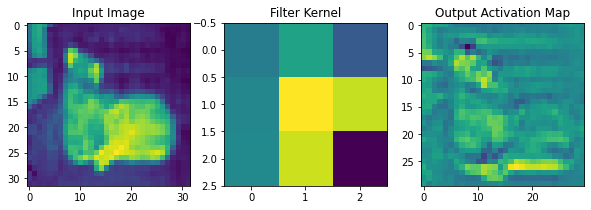

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


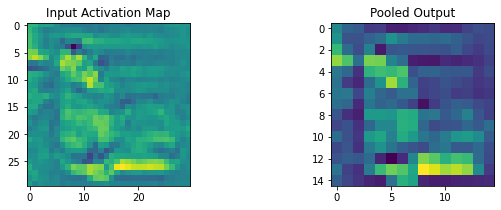

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


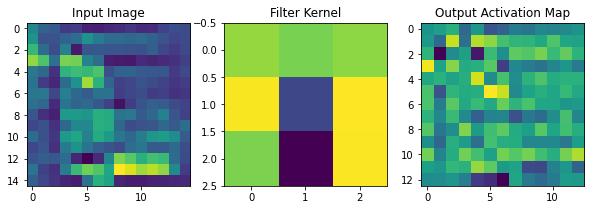

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


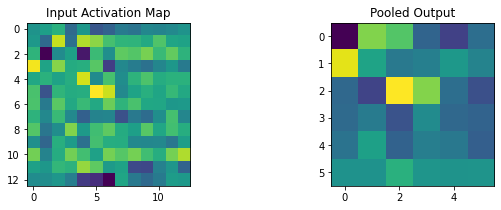

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5992, 0.5992, 0.5992, 0.5992, 0.5992, 0.5992, 0.5992, 0.5992])
MLP output without softmax :  tensor([ 0.8106,  0.5049, -1.7291, -0.5539,  1.5259, -3.1497,  3.8621,  1.1876,
        -3.2576, -0.8054])
MLP output with softmax :  tensor([3.7096e-02, 2.7326e-02, 2.9266e-03, 9.4782e-03, 7.5860e-02, 7.0695e-04,
        7.8452e-01, 5.4085e-02, 6.3464e-04, 7.3711e-03])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


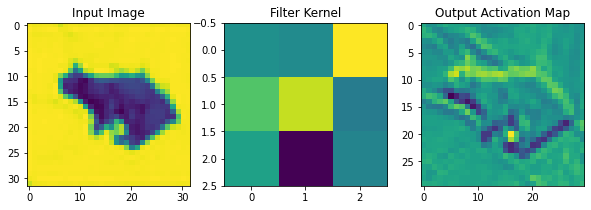

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


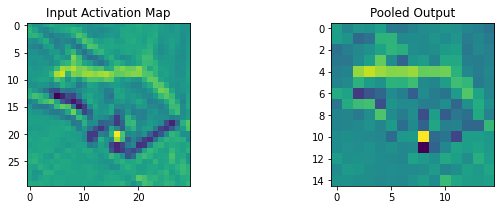

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


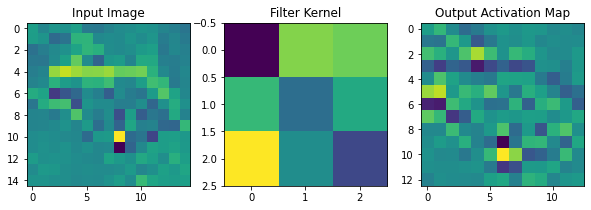

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


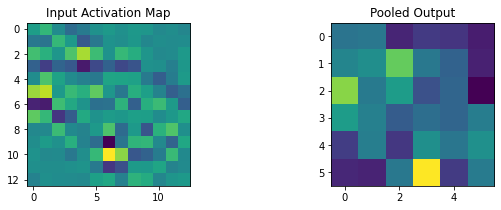

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6233, 0.6233, 0.6233, 0.6233, 0.6233, 0.6233, 0.6233, 0.6233])
MLP output without softmax :  tensor([ 2.8839, -0.7487,  0.3711,  0.6099, -0.9599, -3.6921,  1.2148,  0.5697,
         2.5434,  0.3597])
MLP output with softmax :  tensor([0.4325, 0.0114, 0.0351, 0.0445, 0.0093, 0.0006, 0.0815, 0.0428, 0.3077,
        0.0347])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


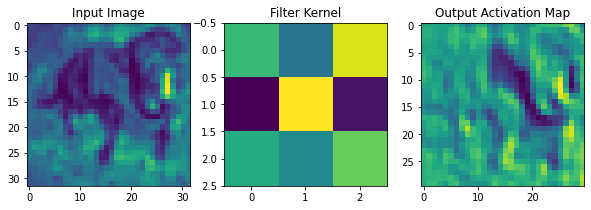

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


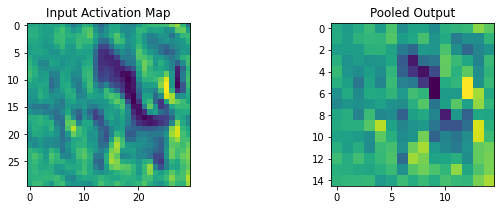

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


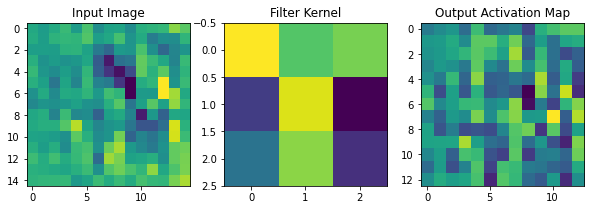

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


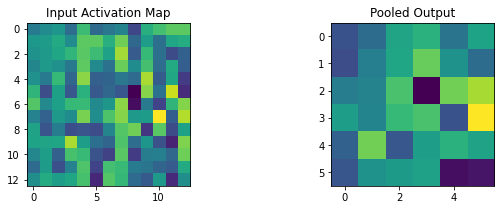

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6631, 0.6631, 0.6631, 0.6631, 0.6631, 0.6631, 0.6631, 0.6631])
MLP output without softmax :  tensor([-0.8818, -1.9370,  1.8978, -3.0931,  0.4955, -2.2504, -3.7753, -2.5043,
         2.4324,  1.0669])
MLP output with softmax :  tensor([0.0177, 0.0062, 0.2849, 0.0019, 0.0701, 0.0045, 0.0010, 0.0035, 0.4862,
        0.1241])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


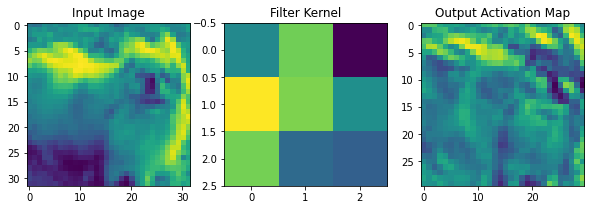

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


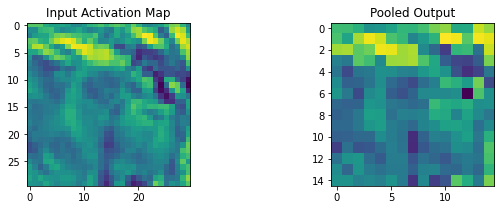

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


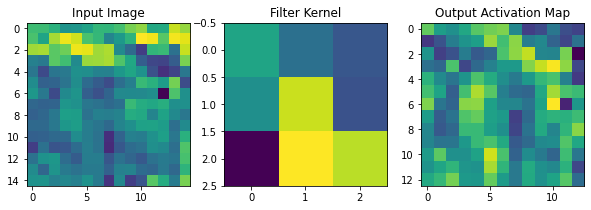

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


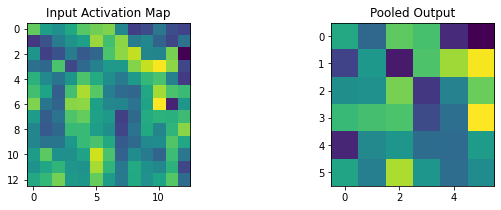

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.5741, 0.5741, 0.5741, 0.5741, 0.5741, 0.5741, 0.5741, 0.5741])
MLP output without softmax :  tensor([ 1.0132,  1.3283,  0.9263,  0.8510, -2.4040, -0.2555,  2.0272,  1.2908,
         1.4680, -2.4443])
MLP output with softmax :  tensor([0.0987, 0.1352, 0.0905, 0.0839, 0.0032, 0.0277, 0.2720, 0.1302, 0.1555,
        0.0031])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


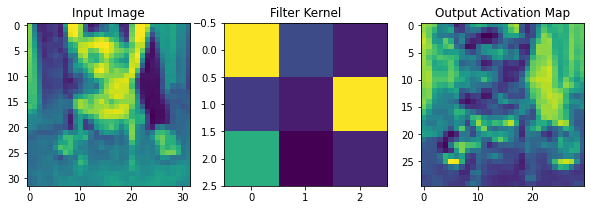

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


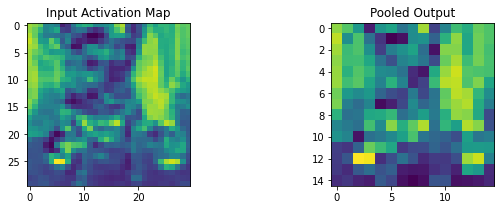

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


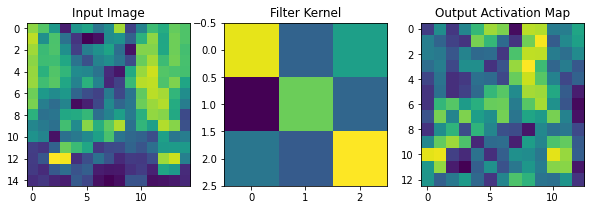

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


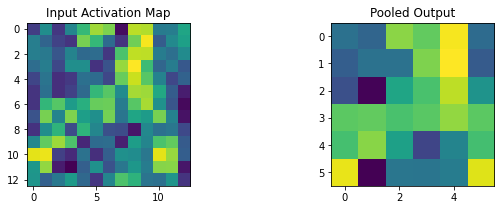

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6617, 0.6617, 0.6617, 0.6617, 0.6617, 0.6617, 0.6617, 0.6617])
MLP output without softmax :  tensor([ 1.8349, -1.7252, -0.5191, -2.0268, -4.7174, -2.1063,  0.9656,  0.5687,
         0.1431,  2.0989])
MLP output with softmax :  tensor([0.2983, 0.0085, 0.0283, 0.0063, 0.0004, 0.0058, 0.1250, 0.0841, 0.0549,
        0.3884])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


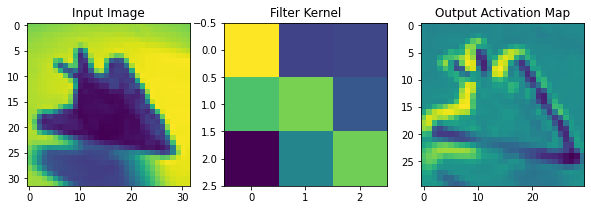

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


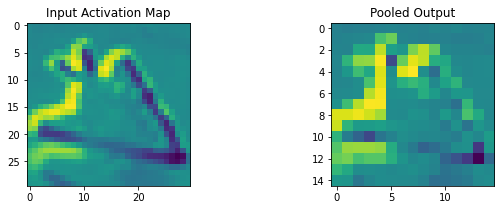

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


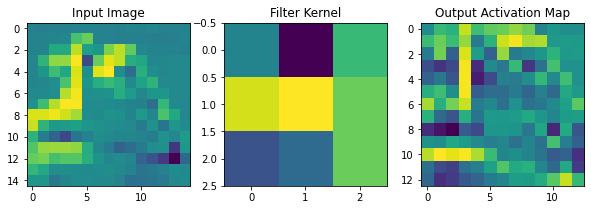

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


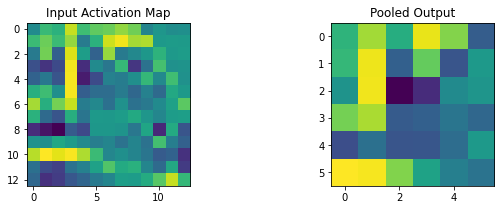

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718])
MLP output without softmax :  tensor([-0.6860, -1.1230, -3.4314, -1.8872,  0.0959,  0.3578,  1.8841,  3.2176,
         1.1986,  1.1390])
MLP output with softmax :  tensor([0.0121, 0.0078, 0.0008, 0.0036, 0.0265, 0.0344, 0.1584, 0.6012, 0.0798,
        0.0752])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


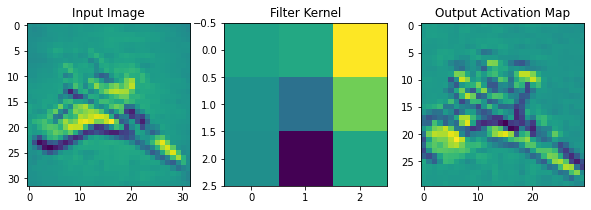

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


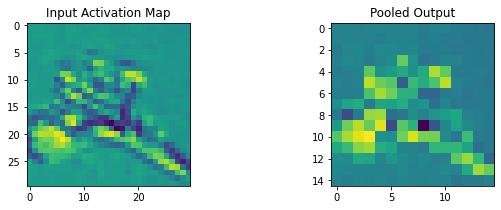

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


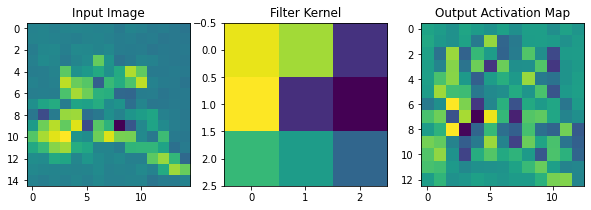

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


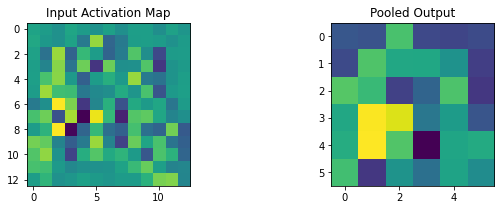

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6401, 0.6401, 0.6401, 0.6401, 0.6401, 0.6401, 0.6401, 0.6401])
MLP output without softmax :  tensor([-0.0977,  0.1999,  1.9268, -0.2545,  0.6949,  0.4441, -2.9800,  3.6094,
         1.5393, -2.7670])
MLP output with softmax :  tensor([0.0165, 0.0222, 0.1247, 0.0141, 0.0364, 0.0283, 0.0009, 0.6711, 0.0847,
        0.0011])


Dimension of input image : 
 torch.Size([3, 32, 32])
filter 1st time size: 
 torch.Size([3, 3, 3])


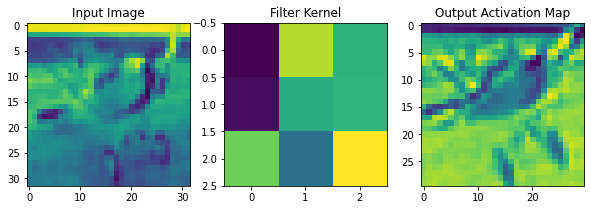

Output size of Convolution Layer 1 
 torch.Size([16, 30, 30])


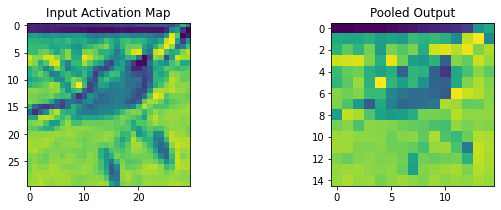

Output size of Pooling Layer 1 
 torch.Size([16, 15, 15])
filter 2nd time size: 
 torch.Size([16, 3, 3])


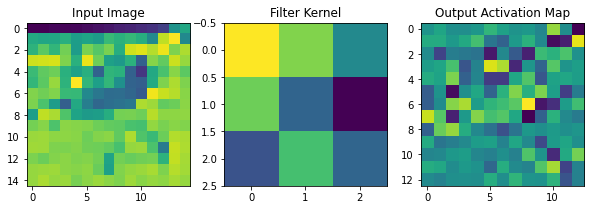

Output size of Convolution Layer 2 
 torch.Size([8, 13, 13])


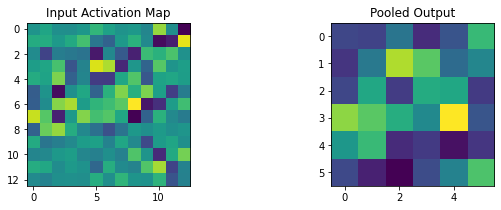

Output size of Pooling Layer 2 
 torch.Size([8, 6, 6])
Shape of output GAP pooling_map : torch.Size([8])
Output size of GAP Pooling Layer 
 torch.Size([8])
Output of GAP Pooling Layer  
 tensor([0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718, 0.6718])
MLP output without softmax :  tensor([ 0.1027, -1.3764,  4.1367,  2.0618, -1.4338, -2.3486, -3.9194,  2.7307,
        -0.0269, -1.7179])
MLP output with softmax :  tensor([1.2498e-02, 2.8476e-03, 7.0596e-01, 8.8648e-02, 2.6888e-03, 1.0771e-03,
        2.2392e-04, 1.7305e-01, 1.0979e-02, 2.0238e-03])






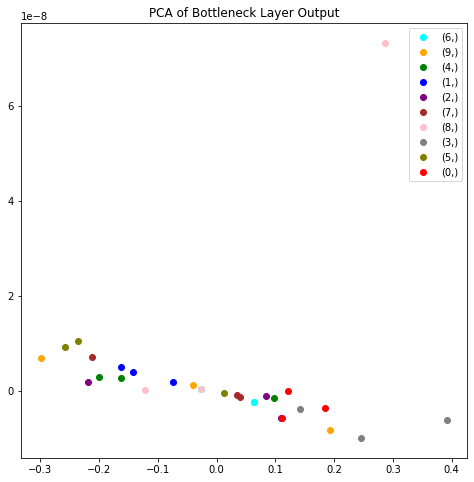

In [20]:
# PCA plot
bottleneck_output = []

for i in range(len(X_train_first3)):
    input_image = X_train_first3[i]
    input_image = input_image.numpy()

    output, pool_map2, gap_output = feed_forward_path(input_image)
    bottleneck_output.append(gap_output.detach().numpy())
bottleneck_output = np.array(bottleneck_output)

# Use PCA to reduce the dimensionality of the bottleneck layer output to 2 dimensions
pca = PCA(n_components=2)
pca_output = pca.fit_transform(bottleneck_output)
# print(pca.components_)
# print(pca.explained_variance_)
print("\n")

# Plot the PCA output
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['cyan', 'orange', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'olive', 'red']
for i in range(len(map)):
    indices = np.where(y_train_first3 == i)[0]
    ax.scatter(pca_output[indices, 0], pca_output[indices, 1], c=colors[i], label=list(map.keys())[i])
    
ax.legend()
ax.set_title('PCA of Bottleneck Layer Output')
plt.show()

### Answer:
When we train a neural network, the weights are initialized randomly and then updated during the training process to fit the training data. Therefore, **a randomly initialized network does not have any meaningful structure that can be used for discriminability.**

In other words, the output of a randomly initialized network for a given input is essentially random noise, and there is no relationship between the output and the class labels. Therefore, a randomly initialized network cannot be used for classification or any other discriminative task.

However, during the training process, the network learns to extract meaningful features from the input data and map them to the corresponding output labels. As the training progresses, the weights are updated to optimize the performance of the network on the training data. This process leads to the development of discriminative features in the network, which enable it to distinguish between different classes.

Therefore, **the discriminability of a neural network is a result of the learning process, and a randomly initialized network does not have any discriminative power.**



